In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler #normalisation
from sklearn.metrics import accuracy_score #scoring

In [ ]:
# Euclidean distance function
def euclidean_distance(v1, v2):
    return np.linalg.norm(v1 - v2)

# Find the Best Matching Unit (BMU)
def find_bmu(input_vector, weights):
    bmu_idx = None
    min_dist = np.inf

    # Compare with each neuron
    for i in range(map_width):
        for j in range(map_height):
            w = weights[i, j]
            dist = euclidean_distance(input_vector, w)
            if dist < min_dist:
                min_dist = dist
                bmu_idx = (i, j)

    return bmu_idx

In [ ]:
# Mexican hat function for calculating influence
def mexican_hat_function(dist_to_bmu, radius):
    gaussian_part = np.exp(-dist_to_bmu**2 / (2 * radius**2))  # Excitation (Gaussian part)
    inhibitory_part = np.exp(-dist_to_bmu**2 / (radius**2))  # Inhibition part
    return gaussian_part - inhibitory_part  # Excitation minus inhibition


# Update neuron weights using the Mexican Hat function
def update_weights_mexican_hat(input_vector, bmu_idx, iteration, weights, map_width, map_height, learning_rate, time_constant):
    # Calculate neighborhood radius with exponential decay
    radius = initial_radius * np.exp(-iteration / time_constant)

    # Update weights of neurons within BMU's neighborhood
    for i in range(map_width):
        for j in range(map_height):
            w = weights[i, j]
            dist_to_bmu = euclidean_distance(np.array([i, j]), np.array(bmu_idx))

            # If the neuron is within the neighborhood
            if dist_to_bmu < radius:
                # Calculate influence using the Mexican Hat function
                influence = mexican_hat_function(dist_to_bmu, radius)
                # Update weights based on calculated influence
                weights[i, j] += influence * learning_rate * (input_vector - w)

    return weights


# Visualization of the Kohonen map weights (1D projection)
def visualize_som_weights(weights):
    plt.figure(figsize=(8, 6))
    sns.heatmap(weights[:, :, 0], cmap="viridis", annot=False, cbar=True)
    plt.title("Kohonen Map (SOM) - Projection of Weights (Dimension 1)")
    plt.show()


# Function for inference with a new input vector
def infer_som(input_vector, weights):
    # Find the BMU for the new input vector
    bmu_idx = find_bmu(input_vector, weights)
    return bmu_idx



# Visualize the map with multiple BMUs
def visualize_bmu_multiple(bmu_indices, weights, sample_classes):
    plt.figure(figsize=(8, 6))
    sns.heatmap(weights[:, :, 0], cmap="viridis", annot=False, cbar=True)
    plt.title("Kohonen Map (SOM) with BMUs for Multiple Samples")

    # Add markers for each BMU
    for idx, bmu_idx in enumerate(bmu_indices):
        #plt.scatter(bmu_idx[1] + 0.5, bmu_idx[0] + 0.5, s=200, c='red', marker='X')
        plt.text(bmu_idx[1] + 0.5, bmu_idx[0] + 0.5, f"C: {sample_classes[idx]}", color='white', fontsize=12, ha='center', va='center')

    plt.show()

# Function to test inference on random samples
def test_inference(X, y, weights):
    # Select n random indices from the dataset
    #sample_indices = np.random.choice(range(len(X)), size=n_samples, replace=False)

    bmu_indices = []
    sample_classes = []

    # For each sample, perform inference and store the BMUs and classes
    #for idx in sample_indice:
    for idx in range(0,X.shape[0]):
        new_data = X[idx]
        #real_class = y.iloc[idx]  # Actual class of the sample

        real_class=y[idx]
        bmu_idx = infer_som(new_data, weights)

        bmu_indices.append(bmu_idx)
        sample_classes.append(real_class)

    # Visualize the Kohonen map with the BMUs of the samples
    visualize_bmu_multiple(bmu_indices, weights, sample_classes)

    # Convert bmu_indices to a format compatible with accuracy_score
    # This is a simplified approach; a more robust solution would involve mapping BMUs to predicted classes
    predicted_classes = [0] * len(bmu_indices) # Placeholder: Needs a proper mapping from BMU to class

    print("Accuracy: ",accuracy_score(y, predicted_classes))


# Function to test inference on random samples
def test_inference_on_random_samples(n_samples, X, y, weights):
    # Select n random indices from the dataset
    sample_indices = np.random.choice(range(len(X)), size=n_samples, replace=False)
    bmu_indices = []
    sample_classes = []
    # For each sample, perform inference and store the BMUs and classes
    for idx in sample_indices:
        new_data = X[idx]
        real_class = y[idx]  # Actual class of the sample
        bmu_idx = infer_som(new_data, weights)

        bmu_indices.append(bmu_idx)
        sample_classes.append(real_class)

    # Visualize the Kohonen map with the BMUs of the samples
    visualize_bmu_multiple(bmu_indices, weights, sample_classes)

    # Convert bmu_indices to a format compatible with accuracy_score
    # This is a simplified approach; a more robust solution would involve mapping BMUs to predicted classes
    predicted_classes = [0] * len(bmu_indices) # Placeholder: Needs a proper mapping from BMU to class

    print("Accuracy: ",accuracy_score(y, predicted_classes))

In [ ]:
from collections import defaultdict, Counter
import pandas as pd

def build_bmu_class_map(X, y, weights):
    bmu_class_map = defaultdict(list)

    for i in range(len(X)):
        bmu = infer_som(X[i], weights)
        # Check if y is a pandas Series and use .iloc, otherwise use direct indexing
        if isinstance(y, pd.Series):
            bmu_class_map[tuple(bmu)].append(y.iloc[i])
        else: # Assume it's a numpy array or similar
            bmu_class_map[tuple(bmu)].append(y[i])


    # Atribui a classe mais comum (votação majoritária) a cada BMU
    bmu_to_class = {bmu: Counter(classes).most_common(1)[0][0]
                    for bmu, classes in bmu_class_map.items()}

    return bmu_to_class

In [ ]:
from sklearn.metrics import accuracy_score

def test_inference2(X, y, weights, bmu_to_class):
    bmu_indices = []
    sample_classes = []
    predicted_classes = []

    for idx in range(len(X)):
        new_data = X[idx]
        real_class = y[idx]

        bmu_idx = infer_som(new_data, weights)
        pred_class = bmu_to_class.get(tuple(bmu_idx), -1)  # -1 se BMU nunca foi ativado antes

        bmu_indices.append(bmu_idx)
        sample_classes.append(real_class)
        predicted_classes.append(pred_class)

    # Visualizar (opcional)
    visualize_bmu_multiple(bmu_indices, weights, sample_classes)

    # Calcular acurácia (ignorando casos -1 se quiser)
    valid_idx = [i for i in range(len(predicted_classes)) if predicted_classes[i] != -1]
    if valid_idx:
        acc = accuracy_score(np.array(y)[valid_idx], np.array(predicted_classes)[valid_idx])
        print("Accuracy:", acc)
    else:
        print("Nenhum BMU conhecido foi ativado.")

    return predicted_classes

In [ ]:
# leitura de dados BankNote
data_file = "../dataset/sample-data/banknote.xlsx"

# Read the Excel file using pandas
df = pd.read_excel(data_file)

# Extract data into NumPy arrays
X = df.iloc[:, :-1].values # Features (all columns except the last one)
y = df.iloc[:, -1].values  # Labels (the last column)

# fit scaler
X = StandardScaler().fit_transform(X)
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,test_size=0.05 )
#train_x, test_x, y_train, y_test = train_test_split(X, y, stratify=y,test_size=0.05 )
print("Shape do DataFrame completo:", df.shape)
print("Shape de X (features):", X_train.shape)
print("Shape de y (rótulo):", y_train.shape)

print("Shape do DataFrame completo:", df.shape)
print("Shape de X (features):", X_test.shape)
print("Shape de y (rótulo):", y_test.shape)

Shape do DataFrame completo: (1372, 5)
Shape de X (features): (1303, 4)
Shape de y (rótulo): (1303,)
Shape do DataFrame completo: (1372, 5)
Shape de X (features): (69, 4)
Shape de y (rótulo): (69,)


In [ ]:
#### Configurações
# Map and data dimensions
map_width = 10
map_height = 10
n_features = X_train.shape[1]  # 8 features
print("Núnmero de atributos:", n_features)
# Random initialization of neuron weights
weights = np.random.rand(map_width, map_height, n_features)

# Learning parameters
learning_rate = 0.4
n_iterations = 20000
initial_radius = max(map_width, map_height) / 2
time_constant = n_iterations / np.log(initial_radius)

Núnmero de atributos: 4


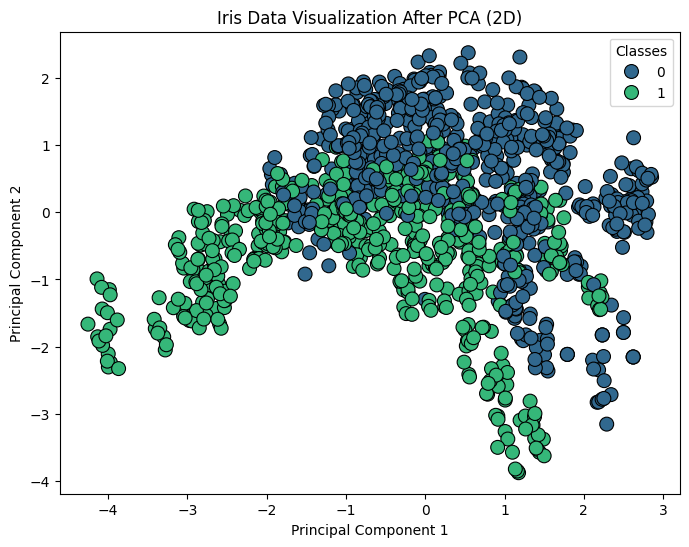

In [ ]:
# Function to visualize the data after PCA
def visualize_data_pca(X, y):
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, palette="viridis", s=100, edgecolor='k')
    plt.title("Iris Data Visualization After PCA (2D)")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.legend(title="Classes", loc="upper right")
    plt.show()

# Call the function to visualize the original data
visualize_data_pca(X_train, y_train)

-------- 0 --------


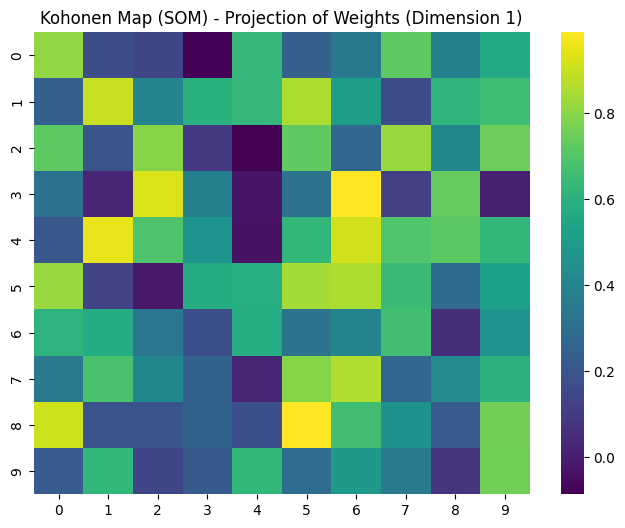

-------- 1000 --------


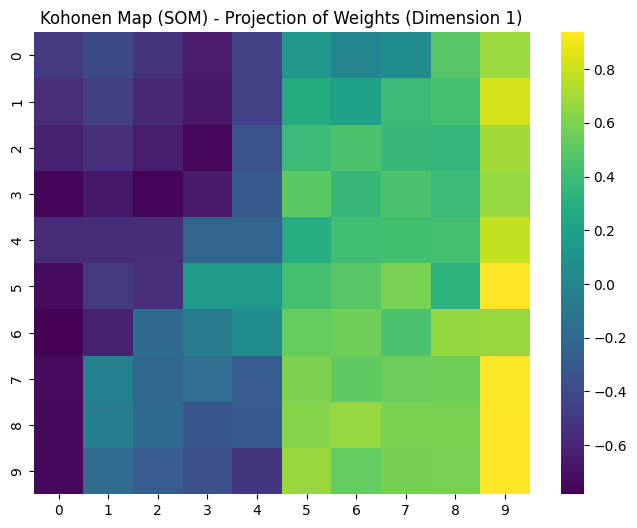

-------- 2000 --------


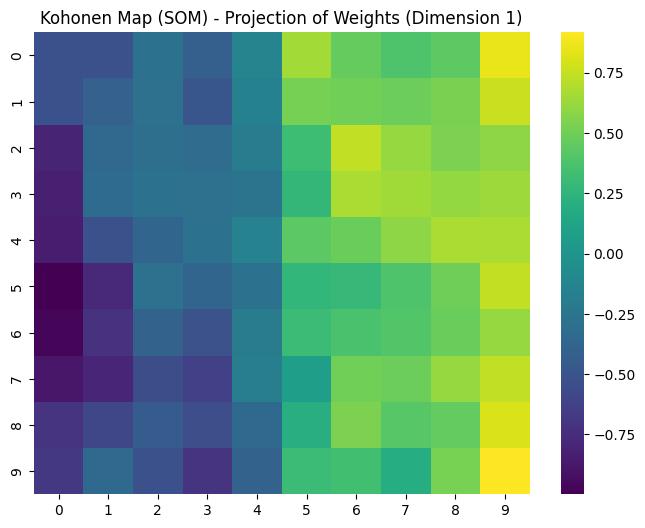

-------- 3000 --------


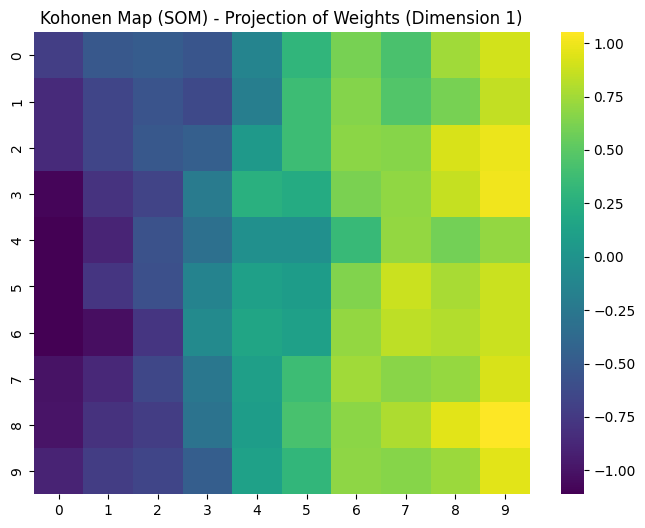

-------- 4000 --------


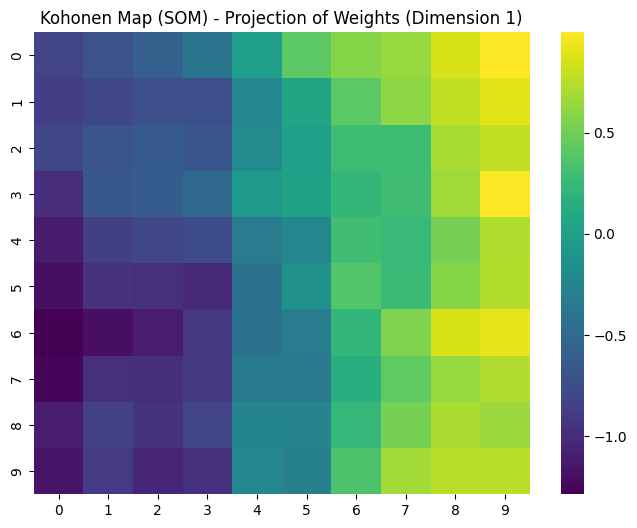

-------- 5000 --------


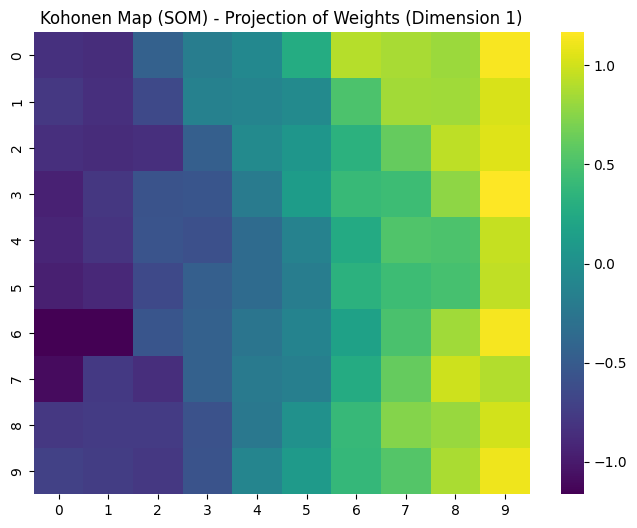

-------- 6000 --------


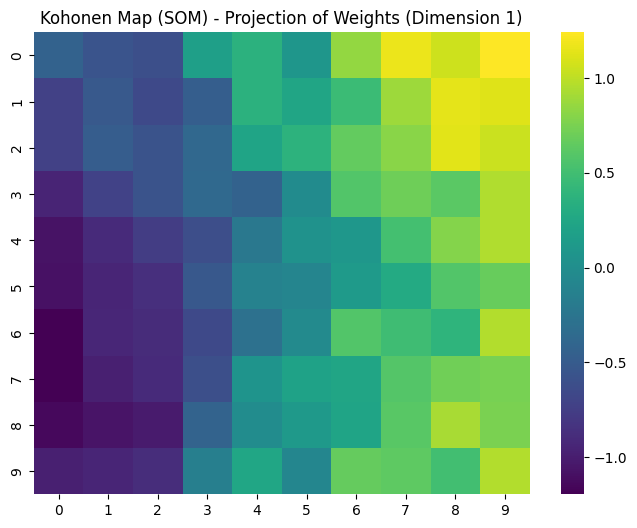

-------- 7000 --------


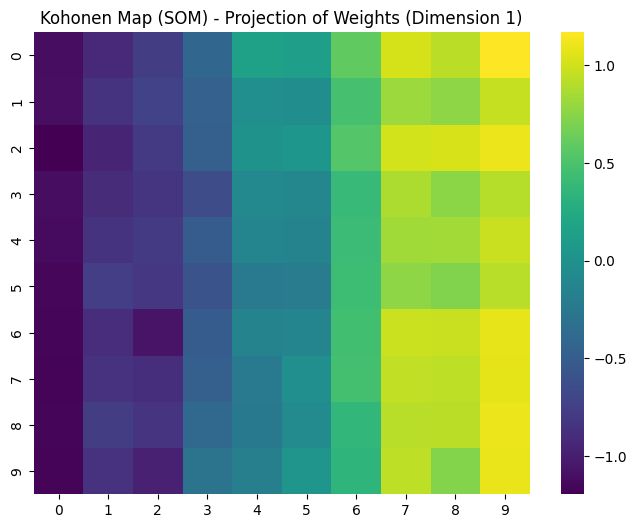

-------- 8000 --------


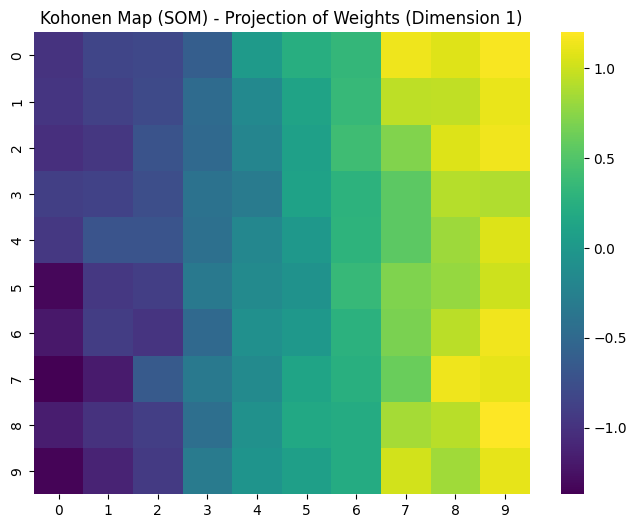

-------- 9000 --------


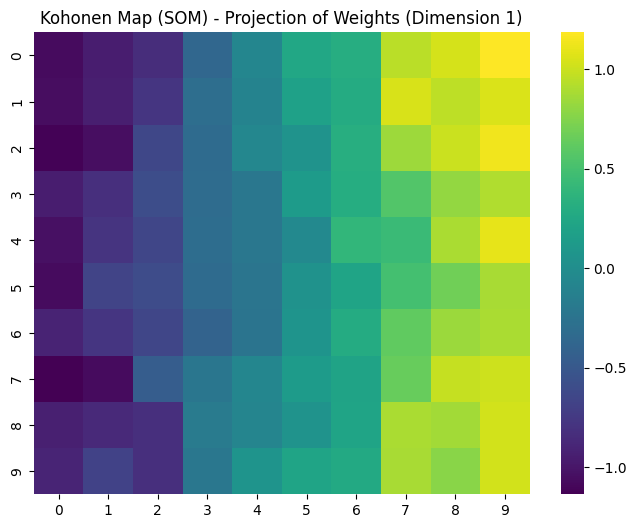

-------- 10000 --------


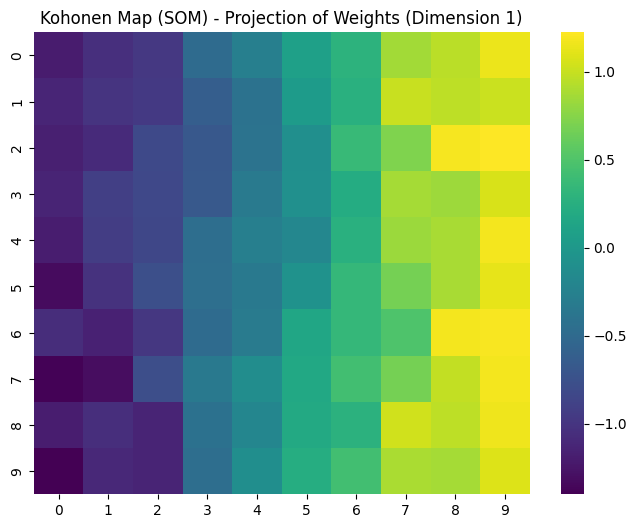

-------- 11000 --------


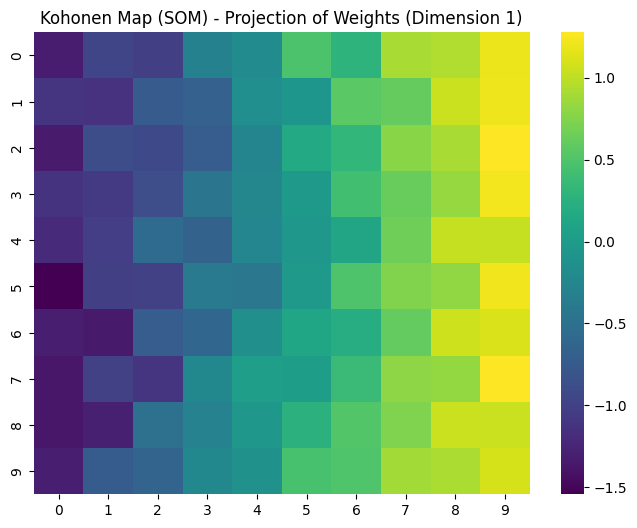

-------- 12000 --------


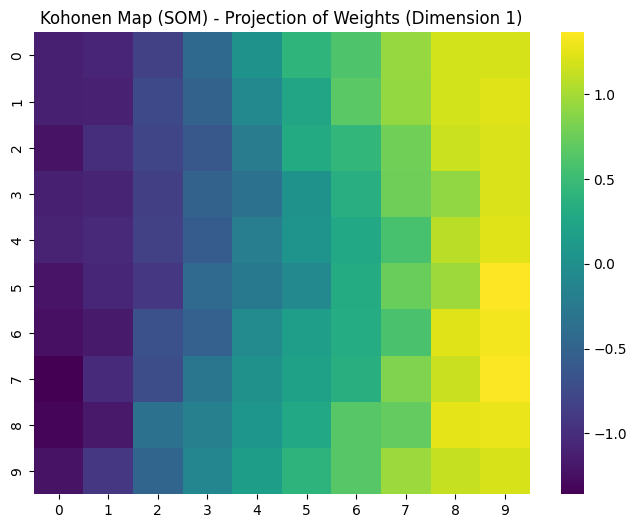

-------- 13000 --------


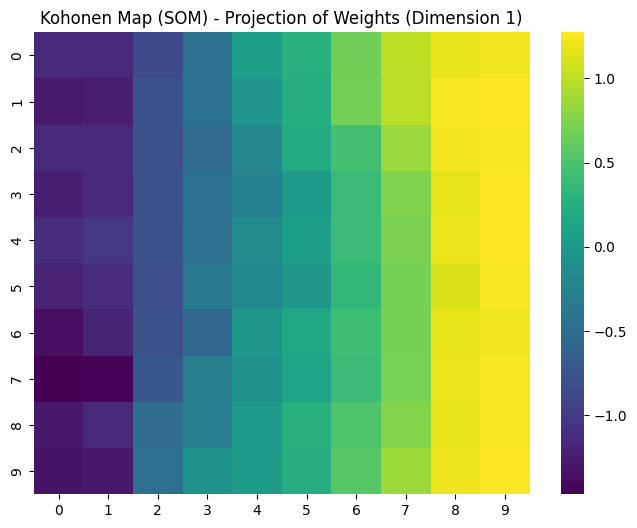

-------- 14000 --------


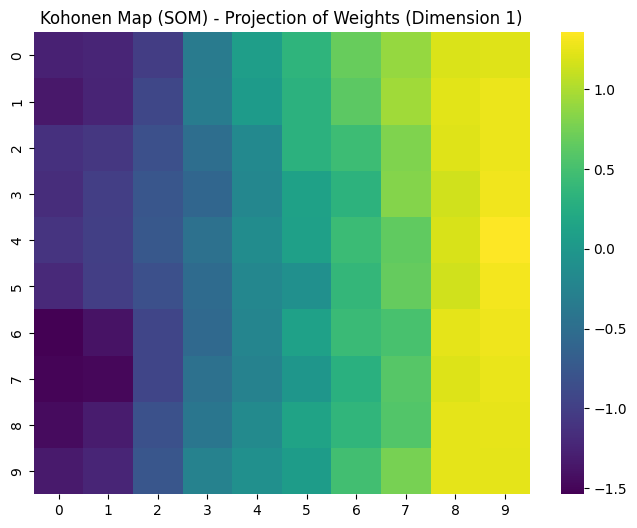

-------- 15000 --------


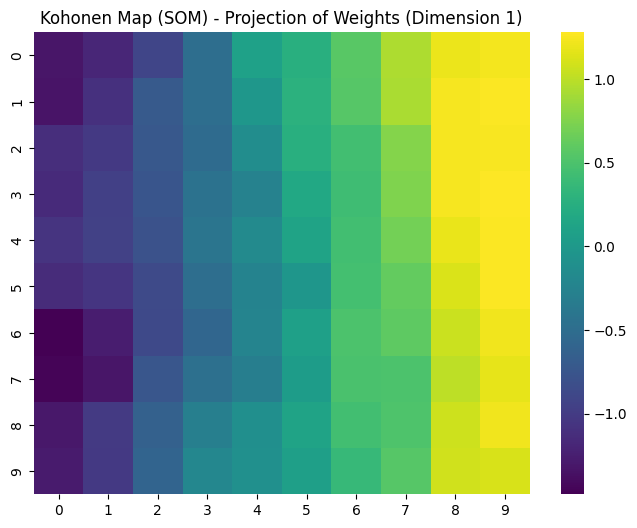

-------- 16000 --------


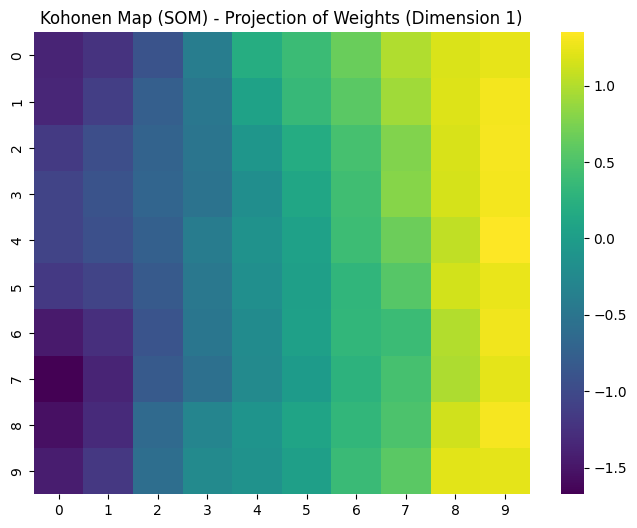

-------- 17000 --------


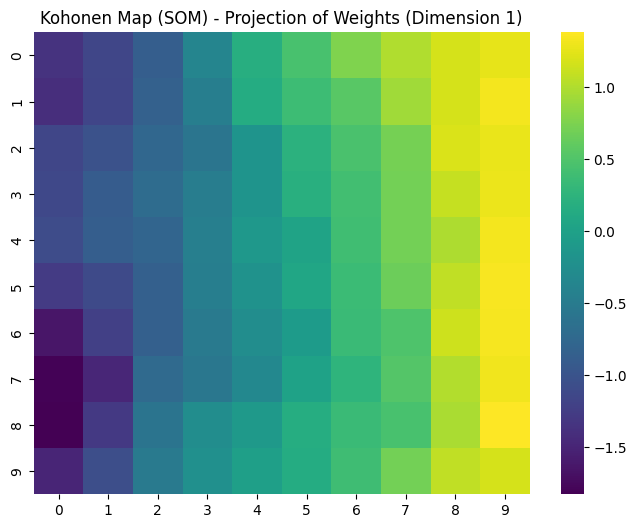

-------- 18000 --------


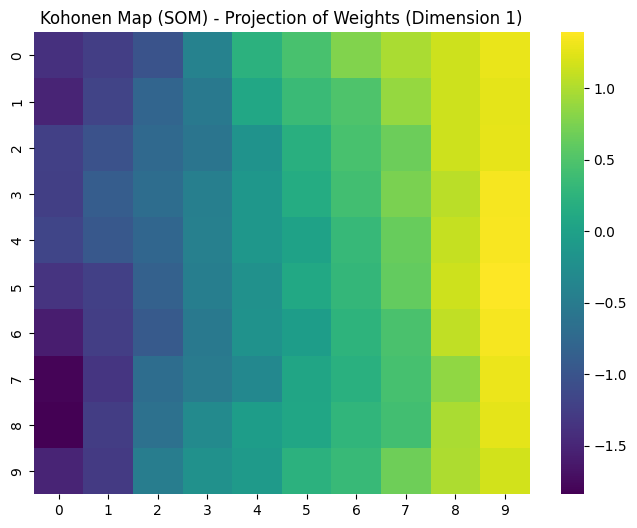

-------- 19000 --------


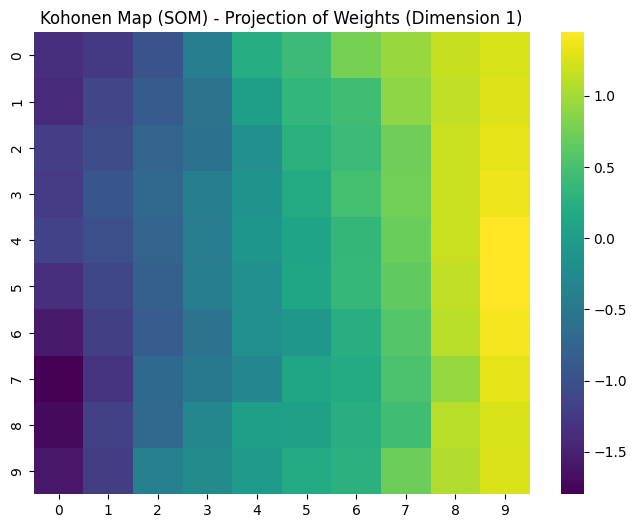

In [ ]:
# Training the KSOM with the Mexican Hat function
for iteration in range(n_iterations):
    # Select a random input vector
    input_vector = X_train[np.random.randint(0, X_train.shape[0])]

    # Find the Best Matching Unit (Best neuron)
    bmu_idx = find_bmu(input_vector, weights)

    # Update the weights of the BMU and neighboring neurons
    weights = update_weights_mexican_hat(input_vector, bmu_idx, iteration, weights, map_width, map_height, learning_rate, time_constant)

    # Gradually reduce the learning rate over iterations
    learning_rate = 0.5 * np.exp(-iteration / n_iterations)
    if iteration%1000==0:
      print("--------",iteration,"--------")
      visualize_som_weights(weights)

    # Call the function to visualize the map after training


In [ ]:
bmu_to_class = build_bmu_class_map(X_train, y_train, weights)
print("BMU to Class Mapping:", bmu_to_class)

BMU to Class Mapping: {(1, 8): np.int64(0), (8, 9): np.int64(0), (5, 3): np.int64(1), (2, 2): np.int64(1), (8, 6): np.int64(0), (9, 3): np.int64(0), (5, 4): np.int64(1), (4, 6): np.int64(0), (9, 4): np.int64(1), (1, 1): np.int64(1), (0, 8): np.int64(0), (3, 8): np.int64(0), (6, 7): np.int64(0), (2, 1): np.int64(1), (6, 2): np.int64(1), (4, 9): np.int64(0), (7, 8): np.int64(0), (9, 9): np.int64(0), (3, 5): np.int64(0), (4, 4): np.int64(1), (3, 1): np.int64(0), (9, 0): np.int64(1), (2, 4): np.int64(0), (1, 9): np.int64(0), (9, 6): np.int64(0), (2, 3): np.int64(1), (2, 9): np.int64(0), (3, 7): np.int64(0), (6, 0): np.int64(1), (8, 2): np.int64(0), (0, 0): np.int64(1), (3, 4): np.int64(1), (3, 3): np.int64(1), (2, 0): np.int64(1), (6, 6): np.int64(0), (7, 9): np.int64(0), (1, 3): np.int64(1), (9, 7): np.int64(0), (5, 1): np.int64(1), (4, 7): np.int64(0), (2, 8): np.int64(0), (0, 4): np.int64(0), (6, 1): np.int64(1), (4, 3): np.int64(1), (9, 8): np.int64(0), (7, 2): np.int64(1), (8, 0): np.

Shape de X (features): (69, 4)
Shape de y (rótulo): (69,)


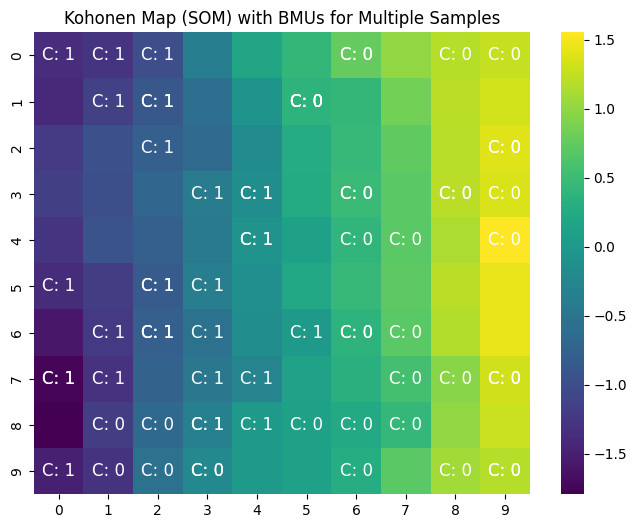

Accuracy: 0.9705882352941176


In [ ]:
# Example usage: Test inference on 20 random samples
print("Shape de X (features):", X_test.shape)
print("Shape de y (rótulo):", y_test.shape)
predicted = test_inference2(X_test, y_test, weights, bmu_to_class)
